## setup

In [1]:
import torch, os, math
import torchvision as tv
import torchvision.transforms.functional as tvf
from torchvision import io
import matplotlib.pyplot as plt
from torch.utils.cpp_extension import load_inline

In [2]:
def show_img(x, figsize=(4,3), **kwargs):
    plt.figure(figsize=figsize)
    plt.axis('off')
    if len(x.shape)==3: x = x.permute(1,2,0)  # CHW -> HWC
    plt.imshow(x.cpu(), **kwargs)


In [3]:
img = io.read_image('puppy.jpg')
print(img.shape)
img[:2,:3,:4]

img2 = tvf.resize(img, 150, antialias=True)
ch,h,w = img2.shape
ch,h,w,h*w

torch.Size([3, 1330, 1920])


(3, 150, 216, 32400)

In [4]:
# RBG-> GRAY
# basic python

def rgb2grey_py(x):
    c,h,w = x.shape
    n = h*w
    x = x.flatten()
    res = torch.empty(n, dtype=x.dtype, device=x.device)
    for i in range(n): res[i] = 0.2989*x[i] + 0.5870*x[i+n] + 0.1140*x[i+2*n]
    return res.view(h,w)

In [5]:
%%time
img_g = rgb2grey_py(img2)

CPU times: user 2.85 s, sys: 11 ms, total: 2.86 s
Wall time: 2.86 s


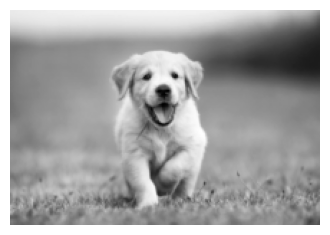

In [6]:
show_img(img_g, cmap='gray')

In [7]:
# python kernel
def run_kernel(f, times, *args):
    for i in range(times): f(i, *args)

def rgb2grey_k(i, x, out, n):
    out[i] = 0.2989*x[i] + 0.5870*x[i+n] + 0.1140*x[i+2*n]


def rgb2grey_pyk(x):
    c,h,w = x.shape
    n = h*w
    x = x.flatten()
    res = torch.empty(n, dtype=x.dtype, device=x.device)
    run_kernel(rgb2grey_k, h*w, x, res, n)
    return res.view(h,w)


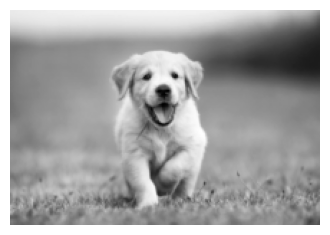

In [8]:
img_g = rgb2grey_pyk(img2)
show_img(img_g, cmap='gray')

In [9]:
def blk_kernel(f, blocks, threads, *args):
    for i in range(blocks):
        for j in range(threads): f(i, j, threads, *args)

def rgb2grey_bk(blockidx, threadidx, blockdim, x, out, n):
    i = blockidx*blockdim + threadidx
    if i<n: out[i] = 0.2989*x[i] + 0.5870*x[i+n] + 0.1140*x[i+2*n]

def rgb2grey_pybk(x):
    c,h,w = x.shape
    n = h*w
    x = x.flatten()
    res = torch.empty(n, dtype=x.dtype, device=x.device)
    threads = 256
    blocks = int(math.ceil(h*w/threads))
    blk_kernel(rgb2grey_bk, blocks, threads, x, res, n)
    return res.view(h,w)

In [10]:
%%time
img_g = rgb2grey_pybk(img2)

CPU times: user 2.89 s, sys: 0 ns, total: 2.89 s
Wall time: 2.88 s


In [12]:
# cuda
os.environ['CUDA_LAUNCH_BLOCKING']='1'
# Wurlitzer 提供了一种优雅的方式来捕获由C级函数产生的标准输出（stdout）和错误输出（stderr）
! conda install -c anaconda wurlitzer -y
%load_ext wurlitzer


Channels:
 - anaconda
 - defaults
 - conda-forge
Platform: linux-64
Solving environment: done


==> WARNING: A newer version of conda exists. <==
    current version: 24.11.3
    latest version: 25.3.1

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - wurlitzer


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    wurlitzer-3.0.2            |  py311h06a4308_0          19 KB  anaconda
    ------------------------------------------------------------
                                           Total:          19 KB

The following NEW packages will be INSTALLED:

  wurlitzer          anaconda/linux-64::wurlitzer-3.0.2-py311h06a4308_0 



                                                                                
Preparing transaction: done
Verifying transaction: done
Executin

In [13]:
def load_cuda(cuda_src, cpp_src, funcs, opt=False, verbose=False):
    return load_inline(cuda_sources=[cuda_src], cpp_sources=[cpp_src], functions=funcs,
                       extra_cuda_cflags=["-O2"] if opt else [], verbose=verbose, name="inline_ext")

In [14]:
cuda_begin = r'''
#include <torch/extension.h>
#include <stdio.h>
#include <c10/cuda/CUDAException.h>

#define CHECK_CUDA(x) TORCH_CHECK(x.device().is_cuda(), #x " must be a CUDA tensor")
#define CHECK_CONTIGUOUS(x) TORCH_CHECK(x.is_contiguous(), #x " must be contiguous")
#define CHECK_INPUT(x) CHECK_CUDA(x); CHECK_CONTIGUOUS(x)

inline unsigned int cdiv(unsigned int a, unsigned int b) { return (a + b - 1) / b;}
'''

In [15]:
cuda_src = cuda_begin + r'''
__global__ void rgb_to_grayscale_kernel(unsigned char* x, unsigned char* out, int n) {
    int i = blockIdx.x*blockDim.x + threadIdx.x;
    if (i<n) out[i] = 0.2989*x[i] + 0.5870*x[i+n] + 0.1140*x[i+2*n];
}

torch::Tensor rgb_to_grayscale(torch::Tensor input) {
    CHECK_INPUT(input);
    int h = input.size(1);
    int w = input.size(2);
    printf("h*w: %d*%d\n", h, w);
    auto output = torch::empty({h,w}, input.options());
    int threads = 256;
    rgb_to_grayscale_kernel<<<cdiv(w*h,threads), threads>>>(
        input.data_ptr<unsigned char>(), output.data_ptr<unsigned char>(), w*h);
    C10_CUDA_KERNEL_LAUNCH_CHECK();
    return output;
}'''

cpp_src = "torch::Tensor rgb_to_grayscale(torch::Tensor input);"

In [16]:
module = load_cuda(cuda_src, cpp_src, ['rgb_to_grayscale'], verbose=True)

Using /root/.cache/torch_extensions/py311_cu124 as PyTorch extensions root...
Creating extension directory /root/.cache/torch_extensions/py311_cu124/inline_ext...
Detected CUDA files, patching ldflags
Emitting ninja build file /root/.cache/torch_extensions/py311_cu124/inline_ext/build.ninja...
/opt/conda/lib/python3.11/site-packages/torch/utils/cpp_extension.py:1964: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module inline_ext...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


[1/3] c++ -MMD -MF main.o.d -DTORCH_EXTENSION_NAME=inline_ext -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /opt/conda/lib/python3.11/site-packages/torch/include -isystem /opt/conda/lib/python3.11/site-packages/torch/include/torch/csrc/api/include -isystem /opt/conda/lib/python3.11/site-packages/torch/include/TH -isystem /opt/conda/lib/python3.11/site-packages/torch/include/THC -isystem /usr/local/cuda/include -isystem /opt/conda/include/python3.11 -D_GLIBCXX_USE_CXX11_ABI=0 -fPIC -std=c++17 -c /root/.cache/torch_extensions/py311_cu124/inline_ext/main.cpp -o main.o 
[2/3] /usr/local/cuda/bin/nvcc --generate-dependencies-with-compile --dependency-output cuda.cuda.o.d -DTORCH_EXTENSION_NAME=inline_ext -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /opt/conda/lib/python3.11/site-packages/torch/i

Loading extension module inline_ext...


In [17]:
[o for o in dir(module) if o[0]!='_']

['rgb_to_grayscale']

In [18]:
imgc = img.contiguous().cuda()

In [19]:
%%time
# 以自定义的设置（运行R次，每一次N遍）来运行代码并计时
res = module.rgb_to_grayscale(imgc).cpu()
h,w = res.shape
h,w,h*w

h*w: 1330*1920
CPU times: user 5.48 ms, sys: 0 ns, total: 5.48 ms
Wall time: 4.04 ms


(1330, 1920, 2553600)

In [ ]:
# get data
import gzip,pickle
from urllib.request import urlretrieve
from pathlib import Path
from torch import tensor

# 下载
MNIST_URL='https://github.moeyy.xyz/https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true'
path_data = Path('data')
path_data.mkdir(exist_ok=True)
path_gz = path_data/'mnist.pkl.gz'
if not path_gz.exists(): urlretrieve(MNIST_URL, path_gz)

# 解压
with gzip.open(path_gz, 'rb') as f: ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
x_train,y_train,x_valid,y_valid = map(tensor, (x_train,y_train,x_valid,y_valid))
x_train.shape,x_train.type()

In [ ]:
imgs = x_train.reshape((-1,28,28))
imgs.shape

torch.manual_seed(1)
weights = torch.randn(784,10)
weights

In [ ]:
# python matmul
m1 = x_valid[:5]
m2 = weights
m1.shape,m2.shape

ar,ac = m1.shape # n_rows * n_cols
br,bc = m2.shape
(ar,ac),(br,bc)

t1 = torch.zeros(ar, bc)
t1.shape

In [ ]:
for i in range(ar):         # 5
    for j in range(bc):     # 10
        for k in range(ac): # 784
            t1[i,j] += m1[i,k] * m2[k,j]

In [ ]:
t1.shape

In [ ]:
import numpy as np
np.set_printoptions(precision=2, linewidth=140)
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)

In [ ]:
t1

In [ ]:
def matmul(a,b):
    (ar,ac),(br,bc) = a.shape,b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            for k in range(ac): c[i,j] += a[i,k] * b[k,j]
    return c

In [ ]:
%time _=matmul(m1, m2)

In [ ]:
ar*bc*ac

In [ ]:
#python kernel

from types import SimpleNamespace as ns

def blk_kernel2d(f, blocks, threads, *args):
    for i0 in range(blocks.y):
        for i1 in range(blocks.x):
            for j0 in range(threads.y):
                for j1 in range(threads.x): f(ns(x=i1,y=i0), ns(x=j1,y=j0), threads, *args)


def matmul_bk(blockidx, threadidx, blockdim, m, n, out, h, w, k):
    r = blockidx.y*blockdim.y + threadidx.y
    c = blockidx.x*blockdim.x + threadidx.x

    if (r>=h or c>=w): return
    o = 0.
    for i in range(k): o += m[r*k+i] * n[i*w+c]
    out[r*w+c] = o

def matmul_2d(m, n):
    h,k  = m.shape
    k2,w = n.shape
    assert k==k2, "Size mismatch!"
    output = torch.zeros(h, w, dtype=m.dtype)
    tpb = ns(x=16,y=16)
    blocks = ns(x=math.ceil(w/tpb.x), y=math.ceil(h/tpb.y))
    blk_kernel2d(matmul_bk, blocks, tpb,
                 m.flatten(), n.flatten(), output.flatten(), h, w, k)
    return output

In [ ]:
res = matmul_2d(m1, m2)
torch.isclose(t1, res).all()

In [ ]:
def matmul(a,b):
    (ar,ac),(br,bc) = a.shape,b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar): c[i] = (a[i,:,None] * b).sum(dim=0)
    return c

In [ ]:
torch.isclose(t1,matmul(m1, m2)).all()

In [ ]:
%time _=matmul(m1, m2)

In [ ]:
m1 = x_train
tr = matmul(m1, m2)
tr.shape

In [ ]:
%time _=matmul(m1, m2)

In [ ]:
ar,ac = m1.shape
br,bc = m2.shape
ar*bc*ac

In [ ]:
# cuda kernel

cuda_src = cuda_begin + r'''
__global__ void matmul_k(float* m, float* n, float* out, int h, int w, int k) {
    int r = blockIdx.y*blockDim.y + threadIdx.y;
    int c = blockIdx.x*blockDim.x + threadIdx.x;

    if (r>=h || c>=w) return;
    float o = 0;
    for (int i = 0; i<k; ++i) o += m[r*k+i] * n[i*w+c];
    out[r*w+c] = o;
}

torch::Tensor matmul(torch::Tensor m, torch::Tensor n) {
    CHECK_INPUT(m); CHECK_INPUT(n);
    int h = m.size(0);
    int w = n.size(1);
    int k = m.size(1);
    TORCH_CHECK(k==n.size(0), "Size mismatch!");
    auto output = torch::zeros({h, w}, m.options());

    dim3 tpb(16,16);
    dim3 blocks(cdiv(w, tpb.x), cdiv(h, tpb.y));
    matmul_k<<<blocks, tpb>>>(
        m.data_ptr<float>(), n.data_ptr<float>(), output.data_ptr<float>(), h, w, k);
    C10_CUDA_KERNEL_LAUNCH_CHECK();
    return output;
}
'''
cpp_src = "torch::Tensor matmul(torch::Tensor m, torch::Tensor n);"


In [ ]:
module = load_cuda(cuda_src, cpp_src, ['matmul'])

In [ ]:
m1c,m2c = m1.contiguous().cuda(), m2.contiguous().cuda()
torch.isclose(tr,module.matmul(m1c, m2c).cpu(), atol=1e-5).all()

In [ ]:
%%time
res=module.matmul(m1c, m2c).cpu()
res.shape

In [ ]:
torch.isclose(tr,(m1c@m2c).cpu(), atol=1e-5).all()

In [ ]:
%timeit -n 10 _=(m1c@m2c).cpu()

In [ ]:
## rgb->grey cuda 3d
cuda_src = cuda_begin + r'''
__global__ void rgb_to_grayscale_kernel(unsigned char* x, unsigned char* out, int w, int h) {
    int c = blockIdx.x*blockDim.x + threadIdx.x;
    int r = blockIdx.y*blockDim.y + threadIdx.y;

    if (c<w && r<h) {
        int i = r*w + c;
        int n = h*w;
        out[i] = 0.2989*x[i] + 0.5870*x[i+n] + 0.1140*x[i+2*n];
    }
}

torch::Tensor rgb_to_grayscale(torch::Tensor input) {
    CHECK_INPUT(input);
    int h = input.size(1);
    int w = input.size(2);
    torch::Tensor output = torch::empty({h,w}, input.options());
    dim3 tpb(16,16);
    dim3 blocks(cdiv(w, tpb.x), cdiv(h, tpb.y));
    rgb_to_grayscale_kernel<<<blocks, tpb>>>(
        input.data_ptr<unsigned char>(), output.data_ptr<unsigned char>(), w, h);
    C10_CUDA_KERNEL_LAUNCH_CHECK();
    return output;
}'''

cpp_src = "torch::Tensor rgb_to_grayscale(torch::Tensor input);"

In [ ]:
module = load_cuda(cuda_src, cpp_src, ['rgb_to_grayscale'])

In [ ]:
%time res = module.rgb_to_grayscale(imgc).cpu()